In [ ]:
print(tf.__version__)
print(keras.__version__)
print(np.__version__)

2.7.0
2.7.0
1.19.5


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def get_noise_sigma(Eb_N0_db, Rr=None, Rc=None):
    assert(not((Rr == None)&(Rc == None)))
    if(Rr == None):
        Rr = Rc/2.
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*Rr*Eb_N0))

In [ ]:
class MostLikelySymbol(Layer):
    """Return the most likely symbol from a softmax input in the
    one hot encoded form.

    This layer is only active at test time as otherwise it would
    stop gradient propogation during training. Also it is useful
    to train with a softmax output to encourage a decisive 
    decision and because it means you can assess confidence.

    # Arguments
        None

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    def __init__(self, **kwargs):
        super(MostLikelySymbol, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
        def most_likely():
            max_vals = K.max(inputs, axis=1, keepdims=True) 
            max_vals = K.cast(max_vals, 'float32')
            geT = K.greater_equal(inputs, max_vals)
            return K.cast(geT, 'float32')            
        return K.in_train_phase(inputs, most_likely, training=training)

    def get_config(self):
        config = {}
        base_config = super(MostLikelySymbol, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
def get_layer_shapes(start, end, num_steps):
    shapes = [start]
    diff = (end-start)/(num_steps-1)
    # Always start with a full dense layer
    for i in range(1,num_steps):
        shapes.append(int(start + i*diff))
    return shapes

In [ ]:
def get_data_set(M, total_size):
    #t0 = time()
    all_one_hot_messages = np.diag(np.ones(M))
    perc_train = 0.75
    perc_valid = 0.1

    ## Making Data Set
    multiple = total_size//M
    diff = total_size - (multiple * M)

    ## Get quotient 
    ## Converted the array into a list because it is significantly
    ## faster
    l = []
    all_one_hot_messages_lst = all_one_hot_messages.tolist()
    for mult in range(multiple):
        for i in range(M):
            l.append([all_one_hot_messages_lst[i]])
    data = np.concatenate(l)

    # Add remainder
    random_inds = np.random.choice(np.arange(M),size=diff, replace=False)
    extra_rows = all_one_hot_messages[random_inds,:]
    data = np.concatenate((data, extra_rows), axis=0)
    np.random.shuffle(data)
    file_path = "./DNN_short_block_comms-master/data/data"+str(M)+".npy"
    
    #np.save(f, np.array([1, 2]))
    with open(file_path, 'wb') as f:
      np.save(f, data)
    #print(f"Took {time() - t0}s")
    return data, file_path, all_one_hot_messages



In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from keras.layers import Input, Dense, Lambda, Add, GaussianNoise, ActivityRegularization
from keras.models import Model
from keras.layers import BatchNormalization 
from keras import backend as K
from keras.layers import advanced_activations
from keras.layers import Layer
from keras.initializers import Zeros as kZeros
from keras import regularizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
#from keras.utils import multi_gpu_model

import numpy as np
from numpy.random import seed
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.stats import norm
from tqdm import tqdm_notebook, tnrange
from time import time
import random as rd

import matplotlib.pyplot as plt

seed(5)
tf.random.set_seed(3.8)

# **DATASET**

In [4]:
#total_size = 1000000
#func_data, file_path, all_one_hot_messages = get_data_set(256, total_size)
data22 = np.load('./drive/MyDrive/Colab-Notebooks/data/data4.npy')
#print(data.shape)

# Test Data
train_data22, test_data22 = train_test_split(data22, \
                                          train_size=0.8)

# # # Train and Validation
train_data22, valid_data22 = train_test_split(train_data22, \
                                          train_size=0.9)

In [5]:
#total_size = 1000000
#func_data, file_path, all_one_hot_messages = get_data_set(256, total_size)
data44 = np.load('./drive/MyDrive/Colab-Notebooks/data/data16.npy')
#print(data.shape)

# Test Data
train_data44, test_data44 = train_test_split(data44, \
                                          train_size=0.8)

# # # Train and Validation
train_data44, valid_data44 = train_test_split(train_data44, \
                                          train_size=0.9)

In [6]:
#total_size = 1000000
#func_data, file_path, all_one_hot_messages = get_data_set(256, total_size)
data88 = np.load('./drive/MyDrive/Colab-Notebooks/data/data256.npy')
#print(data.shape)

# Test Data
train_data88, test_data88 = train_test_split(data88, \
                                          train_size=0.8)

# # # Train and Validation
train_data88, valid_data88 = train_test_split(train_data88, \
                                          train_size=0.9)

In [ ]:
# Verifique o train loss e ajuste a taxa de aprendizagem de acordo com a perda. 
# Ajuste a epoch e batch_size, e batch_size deve ser o maior possível, para que o 
# efeito de aprendizagem seja bom.

# **NEW MODEL AND FIT**

In [8]:
act_f = advanced_activations.LeakyReLU()
act_f.__name__ = 'leakyrelu'

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
8*8

64

In [ ]:
# CUSTOM CLASS PARA SNR TREINO VARIAVEL
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, decreasingSNR=7, logs=None):
    R = 1
    # ebn0_ = np.arange(0, 9, 1)
    # rand_index = rd.randint(0, ebn0_.shape[0]-1)
    # snr = ebn0_[rand_index]
    EbNo_train = 10**(decreasingSNR/10)
    EbNo_train = np.sqrt(1/(2*R*EbNo_train))
    self.model.layers[5].stddev = EbNo_train
    #print('updating sttdev in training')
    print('SNR treino: ', self.model.layers[5].stddev)

In [105]:
# TRAINING AUTOENCODER - Building the model 

def make_model(M, snr_treino=7):
  input_signal = Input(shape=(M,))
  dense1 = Dense(M, activation=act_f)(input_signal)
  dense2 = Dense(2*n_channel, activation='linear')(dense1)

  encoded2 = BatchNormalization()(dense2)
  #encoded3 = Lambda(lambda x: tx_power/np.sqrt(2)*K.l2_normalize(x,axis=-1))(encoded2)
  encoded3 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded2)

  # SNR de treino
  #snr_treino = 7
  EbNo_train = 10**(snr_treino/10)                                              # converting from dB to linear
  noise = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

  #denseDecoded1 = Dense(M, activation='relu')(noise)
  denseDecoded2 = Dense(M, activation=act_f)(noise)
  decoded1 = Dense(M, activation='softmax')(denseDecoded2)

  autoencoder = Model(input_signal, decoded1)
  #sgd = SGD(lr=0.001)
  autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')


  encoder = Model(input_signal, encoded3)

  # making decoder from full autoencoder
  encoded_input = Input(shape=(2*int(n_channel),))
  deco = autoencoder.layers[-2](encoded_input)
  deco = autoencoder.layers[-1](deco)
  decoder = Model(encoded_input, deco)

  symbs_corrupted = Model(input_signal, noise)
                      

  return autoencoder, encoder, decoder, symbs_corrupted

In [ ]:
BER = 10**-5
exp = 2
c = 1 - ((1-BER)**exp)
print(c)

1.9999899999900705e-05


In [10]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 4  
tx_power = 2

k = np.log2(M) #2
k = int(k)

# Channel uses
n = 1 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_, tx, rx = make_model(4, 7)

# ae_.fit(train_data22, train_data22,
#                       epochs=100,
#                       batch_size=2000,
#                       validation_data=(valid_data22, valid_data22),
#                       callbacks=[es])

In [15]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 16  
tx_power = 2

k = np.log2(M) #2
k = int(k)

# Channel uses
n = 1 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_41, tx41, rx41 = make_model(16, 7)      # for constellation!
# ae_44, tx44, rx44 = make_model(16, 7)

ae_41.fit(train_data44, train_data44,
                      epochs=100,
                      batch_size=2000,
                      validation_data=(valid_data44, valid_data44),
                      callbacks=[es])

### Random choice
# noise_change = MyCustomCallback()
# for epoch in range(100):
#   print('Epoch {}/100'.format(epoch+1))
#   ae_44.fit(train_data44, train_data44,
#                   epochs=1,
#                   batch_size=2000,
#                   validation_data=(valid_data44, valid_data44),
#                   callbacks=[noise_change])
  
#   #Escolhe aleatorimente a snr de treino no range de 0-8dB
#   ebn0_ = np.arange(0, 9, 1)
#   rand_index = rd.randint(0, ebn0_.shape[0]-1)
#   snr = ebn0_[rand_index]
#   noise_change.on_epoch_begin(decreasingSNR=snr)
  

  
#noise_change.on_epoch_begin(decreasingSNR=snr_decrease[epoch_batch])

### Choice decreasing SNR (from 8dB to 0dB) every 10 epochs
noise_change = MyCustomCallback()
for epoch_batch in range(10):
  snr_decrease = np.arange(9, -1, -1)
  for epoch in range(10):
    print('Epoch {}/{}/100'.format(epoch+1, epoch_batch+1))    
    ae_44.fit(train_data44, train_data44,
                    epochs=1,
                    batch_size=100,
                    validation_data=(valid_data44, valid_data44),
                    callbacks=[noise_change])
    noise_change.on_epoch_begin(decreasingSNR=snr_decrease[epoch_batch])
    
  

Epoch 1/100
360/360 [==============================] - 2s 4ms/step - loss: 1.7302 - val_loss: 1.0500
Epoch 2/100
360/360 [==============================] - 1s 3ms/step - loss: 0.6193 - val_loss: 0.2714
Epoch 3/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1816 - val_loss: 0.0713
Epoch 4/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0626 - val_loss: 0.0272
Epoch 5/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0293 - val_loss: 0.0132
Epoch 6/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0074
Epoch 7/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0045
Epoch 8/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 9/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 10/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0034 - val_lo

NameError: ignored

In [17]:
### SAVING MODEL
ae_41.save('./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae41_7_b2000.model')
ae_41.save_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae41_7_b2000.h5')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae41_7_b2000.model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae41_7_b2000.model/assets


In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 256
tx_power = 2

k = np.log2(M) #2
k = int(k)

# Channel uses
n = 4 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_88, tx88, rx88 = make_model(256, 7)

ae_88.fit(train_data88, train_data88,
                      epochs=100,
                      batch_size=2000,
                      validation_data=(valid_data88, valid_data88),
                      callbacks=[es])

Epoch 1/100
360/360 [==============================] - 3s 6ms/step - loss: 0.9450 - val_loss: 0.0157
Epoch 2/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0107 - val_loss: 0.0021
Epoch 3/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0036 - val_loss: 8.5042e-04
Epoch 4/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0018 - val_loss: 4.3676e-04
Epoch 5/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 2.5448e-04
Epoch 6/100
360/360 [==============================] - 2s 5ms/step - loss: 7.1406e-04 - val_loss: 1.6033e-04
Epoch 7/100
360/360 [==============================] - 2s 5ms/step - loss: 4.9581e-04 - val_loss: 1.0611e-04
Epoch 8/100
360/360 [==============================] - 2s 5ms/step - loss: 3.5663e-04 - val_loss: 7.3008e-05
Epoch 9/100
360/360 [==============================] - 2s 6ms/step - loss: 2.6435e-04 - val_loss: 5.1566e-05
Epoch 10/100
360/360 [=========================

In [ ]:
### SAVING MODEL
ae_.save('./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae88_7_b2000v2.model')
ae_.save_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae88_7_b2000v2.h5')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae88_7_b2000v2.model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae88_7_b2000v2.model/assets


In [ ]:
wts = ae_.get_layer("batch_normalization_4").get_weights()
#tx_power/np.sqrt(2)*K.l2_normalize(x,axis=-1)

# **EVALUATION OF THE MODEL**

# M = 4  ▶ (2,2) (2,1)...

In [ ]:
# TESTING AUTOENCODER
test_dim1 = test_data22.shape[0]
n_channel21 = 1

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,16,1))
ber22 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim1       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel21))
    
    encoded_signal = tx.predict(test_data22) 
    #print(encoded_signal.shape)

    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data22).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber22[n] = no_errors #/ nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber22[n])


# ber_array_various_snrs.append(ber) 

SNR: -2 BER: 0.273715
SNR: -1 BER: 0.2281
SNR: 0 BER: 0.18702
SNR: 1 BER: 0.14688
SNR: 2 BER: 0.1111
SNR: 3 BER: 0.081535
SNR: 4 BER: 0.05736
SNR: 5 BER: 0.03958
SNR: 6 BER: 0.02589
SNR: 7 BER: 0.016825
SNR: 8 BER: 0.009985
SNR: 9 BER: 0.006265
SNR: 10 BER: 0.00319
SNR: 11 BER: 0.001505
SNR: 12 BER: 0.00064
SNR: 13 BER: 0.0002
SNR: 14 BER: 3e-05
SNR: 15 BER: 2e-05


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-21-7-b2000V2.npy', 'wb') as f:
  np.save(f, ber22)

# M = 16  ▶ (4,4) (4,2)...

In [ ]:
R

1.0

In [ ]:
# TESTING AUTOENCODER
test_dim2 = test_data44.shape[0]
n_channel42 = 4
#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,16,1))
ber42 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim2       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel42))
    
    encoded_signal = tx44.predict(test_data44) 
    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx44.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data44).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber42[n] = no_errors #/ nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber42[n])


# ber_array_various_snrs.append(ber) 

SNR: -2 BER: 0.466375
SNR: -1 BER: 0.399985
SNR: 0 BER: 0.32992
SNR: 1 BER: 0.26094
SNR: 2 BER: 0.194745
SNR: 3 BER: 0.139455
SNR: 4 BER: 0.090935
SNR: 5 BER: 0.05569
SNR: 6 BER: 0.03076
SNR: 7 BER: 0.01529
SNR: 8 BER: 0.006955
SNR: 9 BER: 0.00255
SNR: 10 BER: 0.000825
SNR: 11 BER: 0.000195
SNR: 12 BER: 3e-05
SNR: 13 BER: 5e-06
SNR: 14 BER: 0.0
SNR: 15 BER: 0.0


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/ber-snrVar-44-10eps-b100.npy', 'wb') as f:
  np.save(f, ber42)

# M = 256  ▶ (8,8) (8,4)...

In [ ]:
# TESTING AUTOENCODER
test_dim3 = test_data88.shape[0]
n_channel84 = 4
#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,16,1))
ber84 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim3       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel84))
    
    encoded_signal = tx88.predict(test_data88) 
    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx88.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data88).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber84[n] = no_errors #/ nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber84[n])


# ber_array_various_snrs.append(ber) 

SNR: -2 BER: 0.653775
SNR: -1 BER: 0.558205
SNR: 0 BER: 0.445265
SNR: 1 BER: 0.329465
SNR: 2 BER: 0.21566
SNR: 3 BER: 0.12391
SNR: 4 BER: 0.058505
SNR: 5 BER: 0.022025
SNR: 6 BER: 0.006345
SNR: 7 BER: 0.001275
SNR: 8 BER: 0.000175
SNR: 9 BER: 1e-05
SNR: 10 BER: 0.0
SNR: 11 BER: 0.0
SNR: 12 BER: 0.0
SNR: 13 BER: 0.0
SNR: 14 BER: 0.0
SNR: 15 BER: 0.0


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-84-7-b2000V2.npy', 'wb') as f:
  np.save(f, ber84)

# **COMPARISONS (BPSK, QPSK)**

In [ ]:

def bpsk_encode(int_bit):
    if(int_bit == 0):
        return -1
    elif(int_bit == 1):
        return 1
    else:
        assert(False)
bpsk_encode_vec = np.vectorize(bpsk_encode)


def bpsk_decode(float_bit):
    if(float_bit <= 0.):
        return 0
    elif(float_bit > 0.):
        return 1
    else:
        assert(False)
bpsk_decode_vec = np.vectorize(bpsk_decode)


def get_noise_sigma(Eb_N0_db, Rr=None, Rc=None):
    assert(not((Rr == None)&(Rc == None)))
    if(Rr == None):
        Rr = Rc/2.
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*Rr*Eb_N0))

def get_block_error_rate(test_data, pred_symbs):
    errors = (test_data != pred_symbs)
    block_errors = errors.any(axis=1)
    return block_errors.sum()/block_errors.shape[0]

def bpsk_get_bler(std, test_data):
    # Encode into bpsk
    bpsk_encoded = bpsk_encode_vec(test_data)
    # Add AWGN noise
    noise = std * np.random.randn(bpsk_encoded.shape[0],\
                                  bpsk_encoded.shape[1])
    received = bpsk_encoded + noise
    # Decode from bpsk back to bits
    bpsk_decoded = bpsk_decode_vec(received)

    # Get Block error rate
    return get_block_error_rate(test_data, bpsk_decoded)



In [ ]:
# (8,8)
t0 = time()
Eb_N0_dbs = np.arange(-2, 16.0, 1)
bler_bpsk88 = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
#     print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, Rr=1)
    # Encode, add noise and decode data, then get BLER
    bler_bpsk88[i] = bpsk_get_bler(noise_std, test_data22)
print(f"Took {time() - t0}")




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


1st loop:   0%|          | 0/18 [00:00<?, ?it/s]

Took 21.231407165527344


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/data/bpsk44_ber_neg2_to_15.npy', 'wb') as f:
  np.save(f, bler_bpsk88)

In [120]:
# CONVENTIONAL
bpsk22 = np.load('./drive/MyDrive/Colab_Notebooks/data/bpsk22_4_bler_neg2_to_15.npy')
bpsk88 = np.load('./drive/MyDrive/Colab_Notebooks/data/bpsk88_256_bler_neg2_15.npy')
bpsk44 = np.load('./drive/MyDrive/Colab_Notebooks/data/bpsk44_ber_neg2_to_15.npy')

In [ ]:
# M EVALUATION
a22 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-22-7-b2000.npy')
a44 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-44-7-b2000.npy')
a88 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-88-7-b2000.npy')
a88v2 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-88-7-b2000V2.npy')
a44v2 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-44-7-b2000V2.npy')
a22v2 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-22-7-b2000V2.npy')
#BLER 
# a22 = 1 - (1 - a22)**2
# a44 = 1 - (1 - a44)**4
# a88 = 1 - (1 - a88)**8

In [ ]:
random = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-snrRandom-44.npy')
var = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-snrVar-44-10eps.npy')
fixa = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-44-5-b2000.npy')
# s15 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-15-b2000.npy')
# s20 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-20-b2000.npy')

In [ ]:
QPSK_sim = [1.3007e-01, 1.0367e-01, 7.7570e-02, 5.6430e-02, 3.6810e-02, 2.3200e-02,
 1.2440e-02, 5.6700e-03, 2.2800e-03, 9.4000e-04, 1.8000e-04, 1.0000e-05,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]

QPSK_teorico = [1.30644489e-01, 1.03759096e-01, 7.86496035e-02, 5.62819520e-02,
 3.75061284e-02, 2.28784076e-02, 1.25008180e-02, 5.95386715e-03,
 2.38829078e-03, 7.72674815e-04, 1.90907774e-04, 3.36272284e-05,
 3.87210822e-06, 2.61306795e-07, 9.00601035e-09, 1.33293102e-10,
 6.81018913e-13, 9.12395736e-16]

In [ ]:
ber_88 = [0.3977, 0.3411, 0.2823, 0.2253, 0.1684, 0.1248, 0.0885, 0.0614, 0.0394, 0.0223, 0.0131, 0.0066, 0.0034, 0.0015, 0.0006, 0.0002, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000]
ber_44 = [0.2570, 0.2195, 0.1807, 0.1499, 0.1183, 0.0942, 0.0694, 0.0495, 0.0326, 0.0262, 0.0167, 0.0097, 0.0054, 0.0025, 0.0015, 0.0006, 0.0003, 0.0001, 0.0000, 0.0000, 0.0000]
ber_22 = [0.1516, 0.1303, 0.1103, 0.0900, 0.0759, 0.0565, 0.0456, 0.0316, 0.0265, 0.0188, 0.0128, 0.0081, 0.0052, 0.0029, 0.0018, 0.0008, 0.0004, 0.0002, 0.0001, 0.0000, 0.0000]

In [ ]:
a = '0.1516    0.1303    0.1103    0.0900    0.0759    0.0565    0.0456    0.0316    0.0265    0.0188    0.0128    0.0081    0.0052    0.0029    0.0018    0.0008    0.0004    0.0002    0.0001    0.0000    0.0000'

aaa = ', '.join(a.split('    '))
print(aaa)

0.1516, 0.1303, 0.1103, 0.0900, 0.0759, 0.0565, 0.0456, 0.0316, 0.0265, 0.0188, 0.0128, 0.0081, 0.0052, 0.0029, 0.0018, 0.0008, 0.0004, 0.0002, 0.0001, 0.0000, 0.0000


In [ ]:
#bpsk22
bpsk22a = bpsk22[2:-5]
bpsk44a = bpsk44[2:-5]
bpsk88a = bpsk88[2:-5]

# ber_22a = np.array(ber_22[::2])
# ber_44a = np.array(ber_44[::2])
# ber_88a = np.array(ber_88[::2])

**Batch evaluation with R=1**

In [142]:
b2mil = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-44-7-b2000V2.npy')
b1mil = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/batch-eval-44-7-b1000V2.npy')
b100 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/batch-eval-44-7-b100V2.npy')

Eb_N0_dbs = np.arange(-2, 16.0, 1)

# b2mil = 1 - (1 - b2mil)**4
# b1mil = 1 - (1 - b1mil)**4
# b100 = 1 - (1 - b100)**4

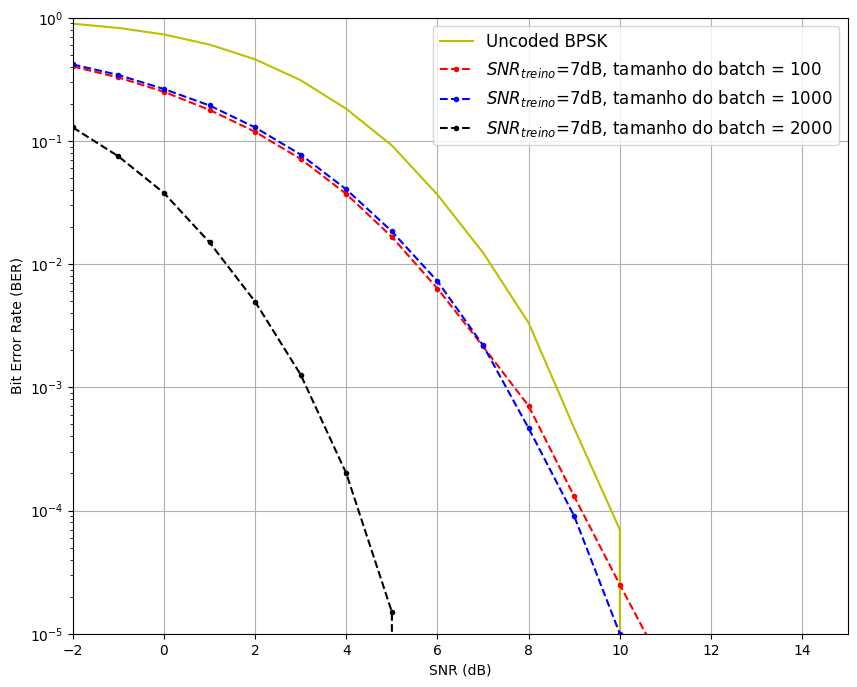

In [148]:
EbNodB_range = np.arange(-2,16,1)

plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, bpsk44, 'y-')
plt.plot(EbNodB_range, b100, 'r.--')
plt.plot(EbNodB_range, b1mil, 'b.--')
plt.plot(EbNodB_range, b2mil, 'k.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-5, 1)
plt.xlim(-2, 15)
plt.legend(["Uncoded BPSK",
            "$SNR_{treino}$=7dB, tamanho do batch = 100",
            "$SNR_{treino}$=7dB, tamanho do batch = 1000",
            "$SNR_{treino}$=7dB, tamanho do batch = 2000"],loc=1, prop={'size': 12})
#plt.title("Efeito do tamanho do batch de amostras")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/batch-eval-44-7-v2.jpeg')
#plt.show()

**M evaluation with R=2**

In [ ]:
a21v2 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-21-7-b2000V2.npy')
a42v2 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-42-7-b2000V2.npy')
a84v2 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-84-7-b2000V2.npy')

Eb_N0_dbs = np.arange(-2, 16.0, 1)

bler21 = 1 - (1 - a21v2)**1
bler42 = 1 - (1 - a42v2)**2
bler84 = 1 - (1 - a84v2)**4

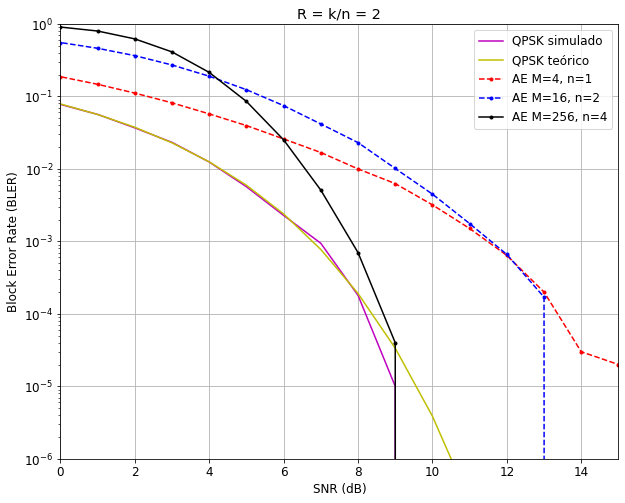

In [ ]:
#plt.plot(EbNodB_range, QPSK_sim, 'y-')
plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, QPSK_sim, 'm-')
plt.plot(EbNodB_range, QPSK_teorico, 'y-')
plt.plot(EbNodB_range, bler21, 'r.--')
#plt.plot(EbNodB_range, ber, 'b.--')
plt.plot(EbNodB_range, bler42, 'b.--')
plt.plot(EbNodB_range, bler84, 'k.-')
# plt.plot(EbNodB_range, s15.reshape(13,), 'g.--')
# plt.plot(EbNodB_range, s20.reshape(13,), 'm.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-6, 1)
plt.xlim(0, 15)
plt.legend(["QPSK simulado",
            "QPSK teórico",
            "AE M=4, n=1",
            "AE M=16, n=2",
            "AE M=256, n=4"])
plt.title("R = k/n = 2")
plt.xlabel("SNR (dB)")
plt.ylabel("Block Error Rate (BLER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/m-eval-r2-v2.png')
#plt.show()

**M evaluation Matlab**

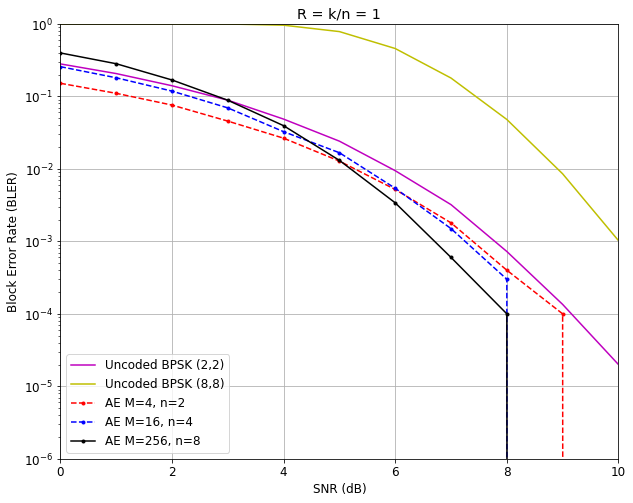

In [ ]:

#plt.plot(EbNodB_range, QPSK_sim, 'y-')
plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, bpsk22a, 'm-')
plt.plot(EbNodB_range, bpsk88a, 'y-')
plt.plot(EbNodB_range, ber_22[::2], 'r.--')
#plt.plot(EbNodB_range, ber, 'b.--')
plt.plot(EbNodB_range, ber_44[::2], 'b.--')
plt.plot(EbNodB_range, ber_88[::2], 'k.-')
# plt.plot(EbNodB_range, s15.reshape(13,), 'g.--')
# plt.plot(EbNodB_range, s20.reshape(13,), 'm.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-6, 1)
plt.xlim(0, 10)
# plt.legend(["QPSK",
#             "$SNR$ escolhida aleatoriamente a cada época",
#             "$SNR$ reduzindo de 8dB a 0dB a cada 10 épocas",
#             "$SNR$ fixa em 5dB"]) #,]
            # "AE $SNR_{treino}$=15dB",
            # "AE $SNR_{treino}$=20dB"])
plt.legend(["Uncoded BPSK (2,2)",
            "Uncoded BPSK (8,8)",
            "AE M=4, n=2",
            "AE M=16, n=4",
            "AE M=256, n=8"], loc=1, prop={'size': 8.7})
#plt.title("R = k/n = 1")
plt.xlabel("SNR (dB)")
plt.ylabel("Block Error Rate (BLER)")
#plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/m-eval-matlab-r1.png')
plt.show()

In [133]:
sn2 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-neg2-b2000.npy')
s5 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-5-b2000.npy')
s7 = np.load('./drive/MyDrive/Colab_Notebooks/data/m-evaluation-88-snr7-b2000.npy')
s15 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-15-b2000.npy')
s20 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-20-b2000.npy')

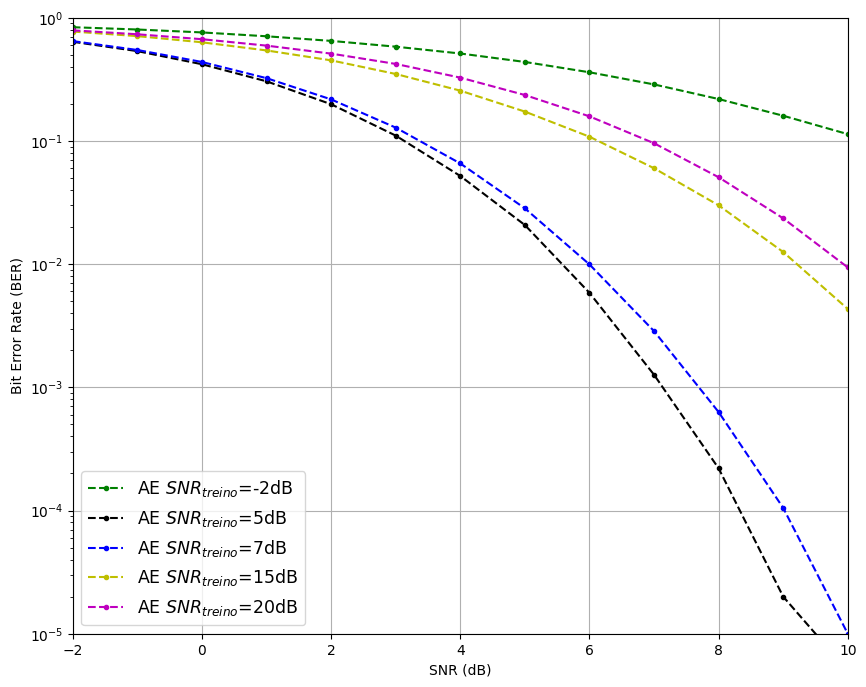

In [141]:
EbNodB_range = np.arange(-2,11,1)

plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, sn2.reshape(13,), 'g.--')
plt.plot(EbNodB_range, s5.reshape(13,), 'k.--')
plt.plot(EbNodB_range, s7.reshape(13,), 'b.--')
plt.plot(EbNodB_range, s15.reshape(13,), 'y.--')
plt.plot(EbNodB_range, s20.reshape(13,), 'm.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-5, 1)
plt.xlim(-2, 10)
plt.legend(["AE $SNR_{treino}$=-2dB",
            "AE $SNR_{treino}$=5dB",
            "AE $SNR_{treino}$=7dB",
            "AE $SNR_{treino}$=15dB",
            "AE $SNR_{treino}$=20dB"],loc=3, prop={'size': 12.5})
#plt.title("Efeito da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/snr-eval-88-fig2.jpeg')
#plt.show()

**Approaches choice of SNR train**

In [119]:
decreasing10eps = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/ber-snrVar-44-10eps-v2.npy')
decreasing10eps_b100 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/ber-snrVar-44-10eps-b100.npy')
random = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/ber-snrRandom-44-v2.npy')
fixa = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/m-eval-44-7-b2000V2.npy')
fixab100 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Uncoded-data/batch-eval-44-7-b100V2.npy')

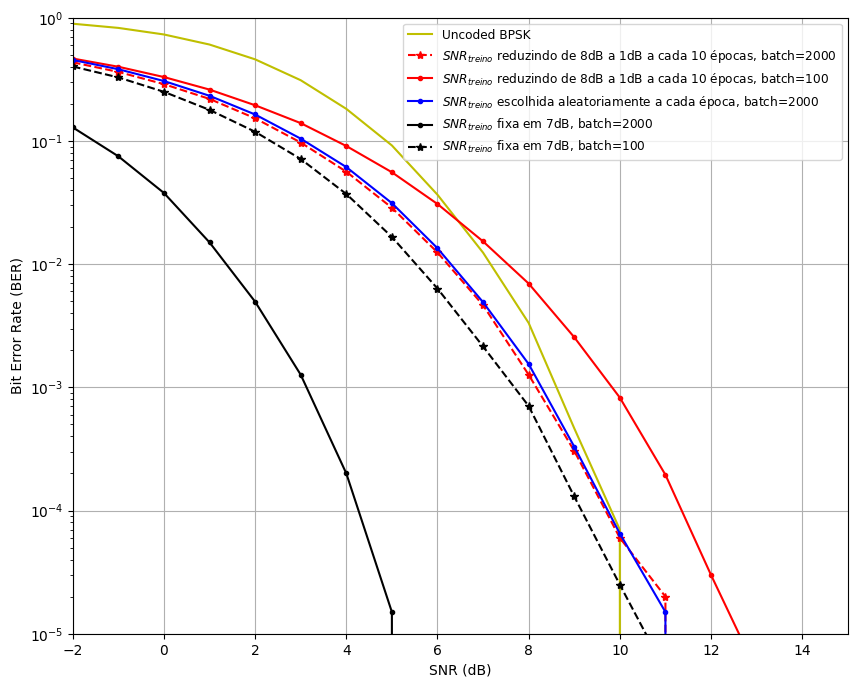

In [132]:
EbNodB_range = np.arange(-2,16,1)

plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, bpsk44, 'y-')
plt.plot(EbNodB_range, decreasing10eps, 'r*--')
plt.plot(EbNodB_range, decreasing10eps_b100, 'r.-')
plt.plot(EbNodB_range, random, 'b.-')
plt.plot(EbNodB_range, fixa, 'k.-')
plt.plot(EbNodB_range, fixab100, 'k*--')
# plt.plot(EbNodB_range, s15.reshape(13,), 'g.--')
# plt.plot(EbNodB_range, s20.reshape(13,), 'm.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-5, 1)
plt.xlim(-2, 15)
plt.legend(["Uncoded BPSK",
            "$SNR_{treino}$ reduzindo de 8dB a 1dB a cada 10 épocas, batch=2000",
            "$SNR_{treino}$ reduzindo de 8dB a 1dB a cada 10 épocas, batch=100",
            "$SNR_{treino}$ escolhida aleatoriamente a cada época, batch=2000",
            "$SNR_{treino}$ fixa em 7dB, batch=2000",
            "$SNR_{treino}$ fixa em 7dB, batch=100"], loc=1, prop={'size': 8.7}) 

#plt.title("Efeito das abordagens de escolha da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/approaches-snr-44-v3.jpeg')
#plt.show()

# **CONSTELAÇÃO**

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 16 
k = np.log2(M) #2
k = int(k)
tx_power = 2
# Channel uses
n = 4 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

#ae = load_model('./drive/MyDrive/Colab_Notebooks/modelsV2/ae21_7_b2000.model')
#ae.load_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/ae21_7_b2000.h5')

In [ ]:
fpar = np.unique(scatter_plot[:,0])
spar = np.unique(scatter_plot[:,2])
fimp = np.unique(scatter_plot[:,1])
simp = np.unique(scatter_plot[:,3])

In [114]:
# scatter_plot = []
# for i in range(0,M):
#     temp = np.zeros(M)
#     temp[i] = 1
M = 4  

k = np.log2(M) #2
k = int(k)

# Channel uses
n = 1 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae21_, tx21, rx21, symbs_noised22 = make_model(4, 7)
ae21_.load_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae21_7_b2000.h5')

scatter_plot = symbs_noised22.predict(test_data22)      #np.expand_dims(temp, axis=0)
#scatter_plot = 1.5/2*scatter_plot

n_channel22 = 2
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
noise_ = noise_std*np.random.randn(test_data22.shape[0],int(n_channel22))

scatter_plot2 = scatter_plot2 + noise_

(200000, 2)


In [117]:
print(scatter_plot2.shape)

(200000, 2)


In [ ]:
# scatter_plot = []
# for i in range(0,M):
#     temp = np.zeros(M)
#     temp[i] = 1
M = 16  

k = np.log2(M) #2
k = int(k)

# Channel uses
n = 2 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae41_, tx41, rx41, symbs_noised = make_model(16, 7)
ae41_.load_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Uncoded-models/ae41_7_b2000.h5')

scatter_plot2 = symbs_noised.predict(test_data44)      #np.expand_dims(temp, axis=0)


# scatter_plot2 = 1.5/2*scatter_plot2

In [96]:
print(scatter_plot2.shape)

(200000, 2)


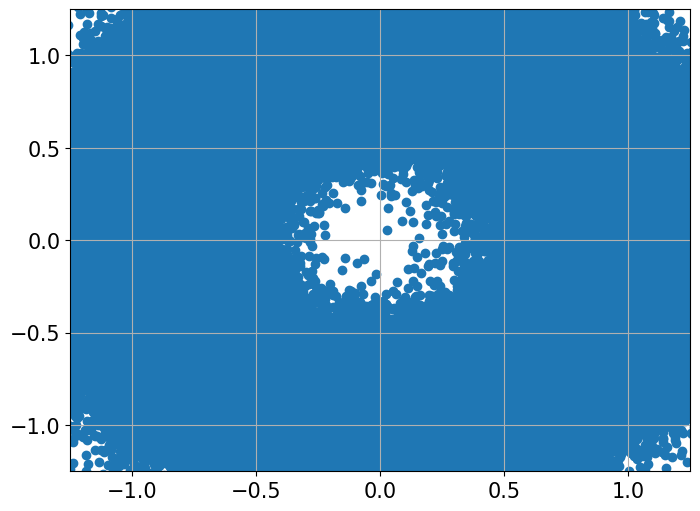

In [118]:
# ploting constellation diagram
#scatter_plot = scatter_plot.reshape(M,2,1)

plt.figure(figsize=(8,6))
plt.scatter(scatter_plot2[:,0], scatter_plot2[:,1])
plt.axis((-1.25,1.25,-1.25,1.25))
plt.grid()
#plt.title('M=4, n=1')
#plt.xlabel('I Axis')
#plt.ylabel('Q Axis')
plt.show()
#plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/const-m16-n4-symb1.png')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Horizontally stacked subplots')
ax1.scatter(scatter_plot[:,0], scatter_plot[:,1])
ax2.scatter(scatter_plot2[:,0], scatter_plot2[:,3])
ax1.axis((-1.25,1.25,-1.25,1.25))
ax1.grid()
ax2.axis((-1.25,1.25,-1.25,1.25))
ax2.grid()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [122]:
 plt.style.use('default')

In [83]:
plt.rcParams.update({'font.size': 18})
#plt.rc('font', weight='')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#plt.rc('lines', lw=2, color='g')

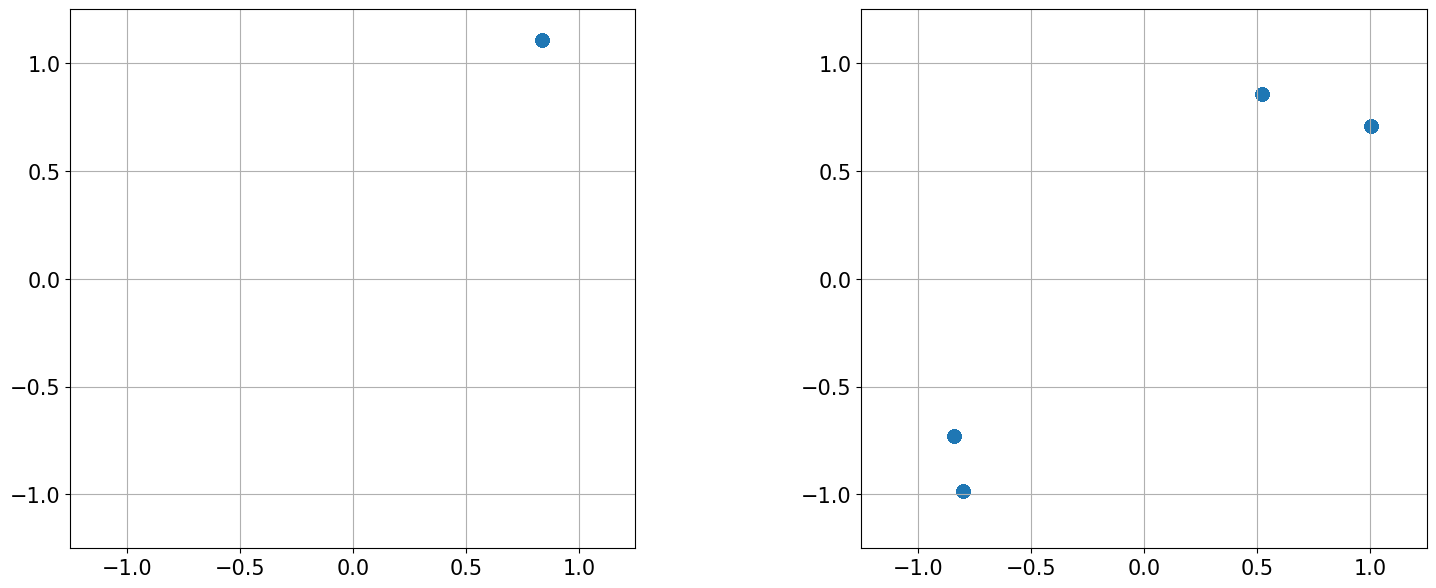

In [108]:
fig = plt.figure(figsize=(10,8))

fig.set_figheight(7)
fig.set_figwidth(17.5)
fig.subplots_adjust(hspace=0.1, wspace=0.4)

# Adds subplot on position 1
ax1 = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)

ax1.scatter(scatter_plot[:,0], scatter_plot[:,1], zorder=1, s=80,alpha=1.0)
ax2.scatter(scatter_plot[:,2], scatter_plot[:,3], zorder=1, s=80,alpha=1.0)
ax1.axis((-1.25,1.25,-1.25,1.25))
ax1.grid()
ax2.axis((-1.25,1.25,-1.25,1.25))
ax2.grid()
# ax1.set_title('Símbolo 1')
# ax2.set_title('Símbolo 2')
#plt.show()

In [102]:
fig.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/const-m4n1-m16n1.jpeg')

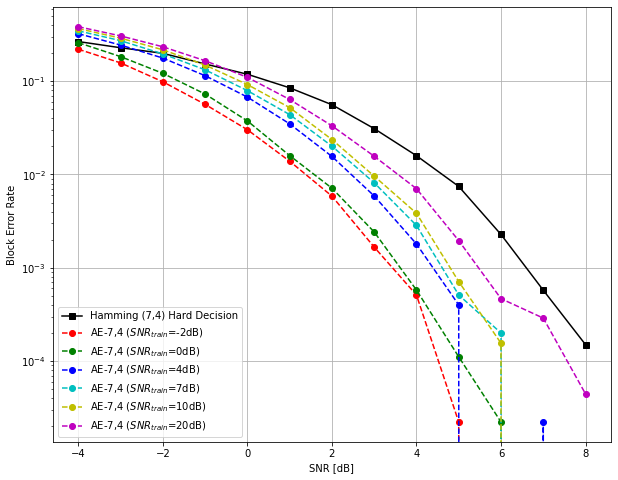

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(SNR, ber_hamming, ls = '-', c = 'k', marker='s')
plt.semilogy(EbNodB_range, ber_array_various_snrs[0], ls = '--', c = 'r', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[1], ls = '--', c = 'g', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[2], ls = '--', c = 'b', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[3], ls = '--', c = 'c', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[4], ls = '--', c = 'y', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[5], ls = '--', c = 'm', marker = 'o')
#plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
#plt.yscale('log')
plt.xlabel('SNR [dB]')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(['Hamming (7,4) Hard Decision', 
            'AE-7,4 ($SNR_{train}$=-2dB)', 
            'AE-7,4 ($SNR_{train}$=0dB)', 
            'AE-7,4 ($SNR_{train}$=4dB)', 
            'AE-7,4 ($SNR_{train}$=7dB)', 
            'AE-7,4 ($SNR_{train}$=10dB)', 
            'AE-7,4 ($SNR_{train}$=20dB)'], loc = 'lower left')
#plt.legend(loc='lower left', ncol = 1)
plt.show()

In [ ]:
print(10**(7/10))

5.011872336272722


In [ ]:
from sklearn.manifold import TSNE
x_emb = encoder.predict(test_data[0:10000])
noise_std = np.sqrt(1/(2*R*EbNo_train))
noise = noise_std * np.random.randn(10000,n_channel)
x_emb = x_emb + noise

X_embedded = TSNE(learning_rate=750, n_components=2, n_iter=5000, random_state=0, perplexity=60).fit_transform(x_emb)
print(X_embedded.shape)
X_embedded = X_embedded/7

plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.axis((-2.5,2.5,-2.5,2.5)) 
plt.grid()
plt.show()